In [1]:
%load_ext autoreload
%autoreload 2

# Start

In [2]:
import sys
sys.path.append("..") 
from nb_002 import *

In [3]:
torch.set_num_threads(1)
DATA_PATH = Path('../data')

In [4]:
import os, shutil

PATH = DATA_PATH/'imagenet'
list_classes = find_classes(PATH/'train')

np.random.seed(42)
random_select = np.random.permutation(list_classes)[:4]

def get_val_folders(class_folders):
    names = [f.name for f in class_folders]
    return [PATH/'val'/name for name in names]

def create_new(class_folders):
    path = Path('../data/sample_imagenet/')
    os.makedirs(path, exist_ok=True)
    for mode in ['train', 'val']:
        p = path/mode
        os.makedirs(p, exist_ok=True)
        for f in class_folders:
            os.makedirs(p/f.name, exist_ok=True)
            list_images = (PATH/mode/f.name).glob('*')
            for img in list_images: shutil.copy(img, p/f.name/img.name)

Uncomment to create the random sample

In [5]:
# create_new(random_select)

In [6]:
PATH = DATA_PATH/'sample_imagenet'

Test of all the different possiblities for a pipeline on imagenet including:
- resizing the image so that the lower dimension is 224
- random rotate -10 to 10 degrees
- random scale 0.9 to 1.1
- random flip
- random crop

# Torchvision

In [7]:
import torchvision

In [8]:
class TVFilesDataset(Dataset):
    def __init__(self, folder, tfms):
        cls_dirs = find_classes(folder)
        self.fns, self.y = [], []
        self.classes = [cls.name for cls in cls_dirs]
        for i, cls_dir in enumerate(cls_dirs):
            fnames = get_image_files(cls_dir)
            self.fns += fnames
            self.y += [i] * len(fnames)
        self.tfms = torchvision.transforms.Compose(tfms)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = Image.open(self.fns[i]).convert('RGB')
        x = self.tfms(x)
        return x,self.y[i]

In [9]:
class DeviceDataLoader():
    def __init__(self, dl, device, stats):
        self.dl,self.device = dl,device
        self.m, self.s = map(lambda x:torch.tensor(x, dtype=torch.float32, device=device)[None,:,None,None], stats)
        
    def __iter__(self):
        for b in self.dl:
            x, y = b[0].to(self.device),b[1].to(self.device)
            x = (x - self.m) / self.s
            yield x,y
    
    def __len__(self): return (len(self.dl))

In [10]:
def get_dataloader(ds, bs, shuffle, stats, device = None, sampler=None):
    if device is None: device = default_device
    dl = DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=8, sampler=sampler, pin_memory=True)
    return DeviceDataLoader(dl, device, stats)

In [11]:
sz, bs = 224, 192
stats = (np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]))
train_tfms = [torchvision.transforms.RandomResizedCrop(sz),
              torchvision.transforms.RandomHorizontalFlip(),
              torchvision.transforms.ToTensor()]

In [12]:
train_ds = TVFilesDataset(PATH/'train', train_tfms)
default_device = default_device = torch.device('cuda', 0)
train_dl = get_dataloader(train_ds, bs, shuffle=False, stats=stats)
len(train_ds),len(train_dl)

(4695, 25)

In [13]:
%time for x,y in tqdm(iter(train_dl), total=len(train_dl)): pass

100%|██████████| 25/25 [00:03<00:00,  7.63it/s]

CPU times: user 1.36 s, sys: 1.28 s, total: 2.64 s
Wall time: 3.28 s


# Pipeline with grid_sampler

Needs the PR https://github.com/pytorch/pytorch/pull/10051/files to make grid_sample fast and support reflect padding/nearest interpolation.

In [14]:
def dict_groupby(iterable, key=None):
    return {k:list(v) for k,v in itertools.groupby(sorted(iterable, key=key), key=key)}

def resolve_pipeline(tfms, **kwargs):
    if len(tfms)==0: return noop
    grouped_tfms = dict_groupby(tfms, lambda o: o.__annotations__['return'])
    lighting_tfms,coord_tfms,affine_tfms,pixel_tfms,final_tfms = [
        resolve_tfms(grouped_tfms.get(o)) for o in TfmType]
    lighting_tfm = apply_lighting_tfm(compose(lighting_tfms))
    affine_tfm = apply_affine_tfm(affine_tfms, func=compose(coord_tfms), **kwargs)
    final_tfm = compose(final_tfms)
    pixel_tfm = compose(pixel_tfms)

    return lambda x,**k: lighting_tfm(final_tfm(affine_tfm(pixel_tfm(x.clone()), **k)))

In [15]:
def get_rrc_params(img, scale, ratio):
    for attempt in range(10):
        area = img.size[0] * img.size[1]
        target_area = random.uniform(*scale) * area
        aspect_ratio = random.uniform(*ratio)

        w = int(round(math.sqrt(target_area * aspect_ratio)))
        h = int(round(math.sqrt(target_area / aspect_ratio)))

        if random.random() < 0.5:
            w, h = h, w

        if w <= img.size[0] and h <= img.size[1]:
            i = random.randint(0, img.size[1] - h)
            j = random.randint(0, img.size[0] - w)
            return i, j, h, w

    w = min(img.size[0], img.size[1])
    i = (img.size[1] - w) // 2
    j = (img.size[0] - w) // 2
    return i, j, w, w

In [16]:
class TransformedFilesDataset(Dataset):
    def __init__(self, folder, sz, tfms=None, classes=None):
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        self.sz, self.tfms = sz, tfms

    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        i,j,h,w = get_rrc_params(x, (0.8,1), (3/4,4/3))
        x = pil2tensor(x)
        x = x[:,i:i+h,j:j+w]
        if self.tfms is not None:
            x = resolve_pipeline(self.tfms, size=self.sz)(x) 
        return x,self.y[i]

In [17]:
stats = (np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]))
train_tfms = [flip_lr_tfm(p=0.5)]

In [18]:
train_ds = TransformedFilesDataset(PATH/'train', sz, train_tfms)
train_dl = get_dataloader(train_ds, bs, shuffle=False, stats=stats)
len(train_ds),len(train_dl)

(4695, 25)

In [19]:
%time for x,y in tqdm(iter(train_dl), total=len(train_dl)): pass

100%|██████████| 25/25 [00:07<00:00,  3.14it/s]

CPU times: user 1.33 s, sys: 1.02 s, total: 2.35 s
Wall time: 7.96 s


## Compare ToTensor() to pil2tensor

In [20]:
class TransformedFilesDataset(Dataset):
    def __init__(self, folder, sz, tfms=None, classes=None):
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        self.sz, self.tfms = sz, tfms

    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        i,j,h,w = get_rrc_params(x, (0.8,1), (3/4,4/3))
        x = torchvision.transforms.ToTensor()(x)
        x = x[:,i:i+h,j:j+w]
        if self.tfms is not None:
            x = resolve_pipeline(self.tfms, size=self.sz)(x) 
        return x,self.y[i]

In [21]:
stats = (np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]))
train_tfms = [flip_lr_tfm(p=0.5)]

In [22]:
train_ds = TransformedFilesDataset(PATH/'train', sz, train_tfms)
train_dl = get_dataloader(train_ds, bs, shuffle=False, stats=stats)

In [23]:
%time for x,y in tqdm(iter(train_dl), total=len(train_dl)): pass

100%|██████████| 25/25 [00:08<00:00,  2.95it/s]

CPU times: user 1.28 s, sys: 888 ms, total: 2.16 s
Wall time: 8.49 s


# With PIL

In [24]:
from PIL import Image

In [25]:
class TransformedFilesDataset(Dataset):
    def __init__(self, folder, sz, tfms=None, classes=None):
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        self.sz, self.tfms = sz, tfms

    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        i,j,h,w = get_rrc_params(x, (0.8,1), (3/4,4/3))
        x = x.crop((j,i,j+w,i+h))
        x = x.resize((self.sz,self.sz), Image.BILINEAR)
        x = pil2tensor(x)
        if self.tfms is not None:
            x = resolve_pipeline(self.tfms)(x)
        return x,self.y[i]

In [26]:
stats = (np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]))
train_tfms = [flip_lr_tfm(p=0.5)]

In [27]:
train_ds = TransformedFilesDataset(PATH/'train', sz, train_tfms)
train_dl = get_dataloader(train_ds, bs, shuffle=False, stats=stats)

In [28]:
%time for x,y in tqdm(iter(train_dl), total=len(train_dl)): pass

100%|██████████| 25/25 [00:03<00:00,  6.50it/s]

CPU times: user 1.38 s, sys: 860 ms, total: 2.24 s
Wall time: 3.85 s


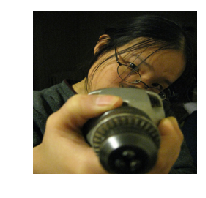

In [29]:
show_image((x*train_dl.s+train_dl.m)[0])

# Just F.interpolate

In [30]:
class TransformedFilesDataset(Dataset):
    def __init__(self, folder, sz, tfms=None, classes=None):
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        self.sz, self.tfms = sz, tfms

    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        i,j,h,w = get_rrc_params(x, (0.8,1), (3/4,4/3))
        x = pil2tensor(x)
        x = x[:,i:i+h,j:j+w]
        x = F.interpolate(x[None], size=(self.sz,self.sz),mode='bilinear', align_corners=True)
        if self.tfms is not None:
            x = resolve_pipeline(self.tfms)(x)
        return x,self.y[i]

In [31]:
stats = (np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]))
train_tfms = [flip_lr_tfm(p=0.5)]

In [32]:
train_ds = TransformedFilesDataset(PATH/'train', sz, train_tfms)
train_dl = get_dataloader(train_ds, bs, shuffle=False, stats=stats)

In [33]:
%time for x,y in tqdm(iter(train_dl), total=len(train_dl)): pass

100%|██████████| 25/25 [00:05<00:00,  4.95it/s]

CPU times: user 1.22 s, sys: 748 ms, total: 1.96 s
Wall time: 5.06 s
